<a href="https://colab.research.google.com/github/michalis0/MGT-502-Data-Science-and-Machine-Learning/blob/main/02_Regression/02_Regression_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Import to load arff file from url
from scipy.io import arff
import urllib.request
import io 

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.model_selection import KFold, cross_val_score # Cross validation
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.preprocessing import PolynomialFeatures # Polynomial features
from sklearn.preprocessing import LabelEncoder #Label encoding
from sklearn.preprocessing import OneHotEncoder # 1-hot encoding
from sklearn.linear_model import LinearRegression # Regression linear model
from sklearn.linear_model import Lasso # Lasso model
from sklearn.linear_model import Ridge # Ridge model
from sklearn.linear_model import LassoCV # Lasso with cross validation
from sklearn.linear_model import RidgeCV # Ridge with cross validation
from sklearn.linear_model import ElasticNet # ElasticNet model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Metrics for errors

# Regression

<img src='https://imgs.xkcd.com/comics/linear_regression.png' width="400">

Source: [xqcd 1725](https://xkcd.com/1725)

## Content

The goal of this walkthrough is to provide you with insights on regression. After presenting the main concepts, you will be introduced to the techniques to implement these concepts in Python. Finally, it will be your turn to practice, using an application on energy efficiency. 

This notebook is organized as follows:
- [Background](#Background)
    - [Objective](#Objective)
    - [Econometrics vs ML](#A-quick-word-on-econometrics-vs-Machine-Learning)
    - [Model](#Model)
        - [Least squares problem](#Least-squares-problem)
        - [Regularization](#model-regul)
        - [Why LASSO leads to feature selection?](#Why-LASSO-leads-to-feature-selection?)
    - [Solving our model: learning parameters via gradient descent](#Solving-our-model:-learning-parameters-via-gradient-descent)
- [Implementation](#Implementation)
    - [Load and discover the dataset](#Load-and-discover-the-dataset)
    - [Linear regression](#Linear-regression)
        - [Splitting the dataset](#linear-split)
        - [Create and Fit model](#linear-train)
        - [Prediction and Evaluation](#linear-test)
    - [Multivariate-linear regression](#Multivariate-linear-regression)
        - [Splitting the dataset](#multivariate-split)
        - [Encoding](#Preprocessing:-encoding-categorical-variables)
        - [Rescaling](#rescaling)
        - [Create and Fit model](#multivariate-train)
        - [Prediction and Evaluation](#multivariate-test)    
    - [Polynomial linear regression](#Polynomial-linear-regression)
    - [Regularization](#Regularization)
        - [Ridge](#Ridge)
        - [Lasso](#Lasso)
    - [K-fold cross validation](#K-fold-cross-validation)
- [Your turn](#Your-turn)

## Background

### Objective

The goal of a regression is to estimate the relationships between a dependent variable (aka outcome, response, or label) and one or more independent variables (aka features, predictors, or explanatory variables).

Why?
- Predict outcome values
- Causal inference: analyze causal relation, for instance to provide policy recommendations
- Test a model / hypothesis
- ...


### A quick word on econometrics vs Machine Learning

- Machine Learning and Econometrics both gather a collection of methods, including (linear) regression, that can be used to answer a research question.
- The roots of ML is computer sciences while Econometrics is applied statistics, but...
- ...each field shares a lot: they are built on a similar mathematical bricks such as linear algebra, optimization, statistics & probability theory
- They (generally) differ on their goal and approach used:
    - Econometrics is often interested in causal interpretation. To do so, you make assumptions about how your data was generated (i.e., from which distribution)
    - The goal of ML is prediction accuracy. To do so, you train an algorithm on a subset of your data and then test this model (and train again...)
- That being said, this is an oversimplification since there are strong overlaps between the two: e.g. ML can also be interested in causality and ML algorithms make (implicit) assumptions.

### Model

Suppose we have *n* observations of an outcome $\boldsymbol{y}$ and *d* associated features $\boldsymbol{x_1}$, $\boldsymbol{x_2}$, ... , $\boldsymbol{x_d}$ (note that $\boldsymbol{y}$, $\boldsymbol{x_1}$, ..., $\boldsymbol{x_d}$ are vectors):

| | Outcome | Feature 1 | Feature 2 | ... | Feature d |
|:-------|:----------:|:----------:|:----------:|:----------:|:----------:|
| Observation 1 | $y_1$ | $x_{11}$ | $x_{12}$ | ... | $x_{1d}$ |
| Observation 2 | $y_2$ | $x_{21}$ | $x_{22}$ | ... | $x_{2d}$ |
| ... | ... | ... | ... | ... | ... |
| Observation n | $y_n$ | $x_{n1}$ | $x_{n2}$ | ... | $x_{nd}$ |

Regression is to relate feature variables to the outcome variable, to either predict outcomes for new observations and/or to understand the effect of the features on the output. For both goals, we need to find a function that approximates the output “well enough” given some inputs.

For instance, in the case of multivariate linear regression, we can write, for each observation $i$:
$$y_i = w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d} + \epsilon_i $$

Where $\epsilon_i$ is the error term, $w_0$ the intercept, and $w_1$, ... , $w_d$ the slope coefficients (i.e., weights) of each feature.

For each observation, we call our predicted value: 
$$\hat{y_i}:=w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d}$$

In other words, we have: $y_i = \hat{y_i} + \epsilon_i $ 

More generally, let $f$ be our model function, $\boldsymbol{w}=(w_0, w_1, ..., w_d)$ the vector of weights, and $\boldsymbol{X}=[\boldsymbol{x_1}$, ... , $\boldsymbol{x_d}]$ the matrix of feature variables. For all observations, we have, with $\boldsymbol{X_{i*}}$ the $i^{th}$ row:

$$\hat{y_i} := f(\boldsymbol{X_{i*}}, \boldsymbol{w})$$

In our illustration, we have focused on a multivariate linear regression, but the formulation will be the same for more complex models, such as neural networks, which we will see later in this course.

Now our objective is to find the predicted values $\hat{y_i}$ that are the closest to the observations $y_i$. In other words, we want to minimize the errors $\epsilon_i = y_i - \hat{y_i}$. There are several possible techniques. Below, we present the simplest one, namely the *least squares* problem.

#### Least squares problem

The idea is to minimize the sum of squared residuals (aka RSS - Residual Sum of Squares):

$$ \min_{\boldsymbol{w}} \sum_{i=1}^n (y_i - \hat{y_i})^2 = \min_{\boldsymbol{w}} \sum_{i=1}^n (y_i - f(\boldsymbol{X_{i*}}, \boldsymbol{w}))^2 $$

Graphically, for a simple linear regression, we minimize the area of the squares between our observation and our predicted value:  

<img src='https://upload.wikimedia.org/wikipedia/commons/8/86/Coefficient_of_Determination.svg' width="600">

Source: [Wikipedia - Coefficient of determination. Author: Orzetto](https://commons.wikimedia.org/wiki/File:Coefficient_of_Determination.svg)

The [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ informs about the goodness of fit: $R^2= 1 -\frac{\color{blue}{RSS}}{\color{red}{TSS}} $
- Residual Sum of Squares: $\color{blue}{RSS=\sum_i (y_i - \hat{y_i})^2}$
- Total Sum of Squares: $\color{red}{TSS=\sum_i (y_i - \bar{y})^2}$

When $R^2=1$, then $RSS=0$, meaning all the errors are equal to zero, and the model gives "perfect" prediction.  
When $R^2=0$, then $RSS=TSS$, hence our model is not more informative that taking the average of our observations.

The prediction errors will generally decrease with the complexity of the model, e.g., with more features. But what could go wrong?
- The prediction error decreases but... there is a risk of overfitting: the model cannot be generalized!
- There may be no solutions (risk of multicollinearity of matrix $\boldsymbol{X}$)

<img src='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*WXi_7HIL3FKETFdfegcEmA.png' width="600">



Source: Ann Sajee, [Model complexity accuracy and interpretability, Towards Data Science](https://medium.com/towards-data-science/model-complexity-accuracy-and-interpretability-59888e69ab3d)

#### Regularization <a id='model-regul'></a>

Our objective is to tackle the limitations of the least square problem, in particular [overfitting](https://en.wikipedia.org/wiki/Overfitting). An overfitted model contains more parameters than can be justified by the data. 

What can we do? One technique is called [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics))

The general idea is to put an additional constraint - or penalty - on our parameters $\boldsymbol{w}$, instead of optimizing only on the errors. Here is the new problem formulation:

$$ \min_{\boldsymbol{w}} L(\boldsymbol{y}, \boldsymbol{X}, \boldsymbol{w}) + \lambda R(\boldsymbol{w}) $$

- $L(\boldsymbol{y}, \boldsymbol{X}, \boldsymbol{w})$ is the **loss** function. It measures the prediction error. 
    - For instance, we can use the least square loss function:
$ L(\boldsymbol{y}, \boldsymbol{X}, \boldsymbol{w}) = \frac{1}{n} \sum_i^n (y_i - f(\boldsymbol{X_{i*}}, \boldsymbol{w}))^2 $
- $\lambda$ is the penalty term
- $R(\boldsymbol{w})$ is the **regularization** function that constrains the model, typically penalizing the parameters $w_0$, $w_1$, ..., $w_d$. What regularization function should we use? Below are some common examples...

**LASSO**  regression, standing for "Least Absolute Selection and Shrinkage", is using the 1-norm ([absolute value norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Absolute-value_norm)) of the parameters as regularization function: 
$$ R(\boldsymbol{w})= \sum_{j=1}^d |w_j| $$

- Pros
    - Force most entries of $\boldsymbol{w}$ to be 0. In other words, there is selection effect, and the technique is preferred when $\boldsymbol{w}$ is expected to be sparse
    - It enables to do a linear regression when there are more features than observations ($d > n$)
- Cons
    - Arbitrary selection among highly correlated variables
    - Selects at most $n$ features when more features than observations ($d > n$)
    - Features with small $w_j$ values will be forced to zero

**Ridge** regression is using the square of the 2-norm ([Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm)) of the parameters as regularization function: $$R(\boldsymbol{w})= \sum_{j=1}^d w_j^2 $$

- Pros
    - More stable solution (shrink parameters estimate). This method is thus preferred when $\boldsymbol{w}$ is expected to take small values
    - It enables to do a linear regression when there are more features than observations ($d > n$)
- Cons
    - Less sensitive to data
    - $\boldsymbol{w}$ is typically still not sparse

**Elastic net** regression is using a linear combination of Ridge and Lasso: $$ R(\boldsymbol{w})= \lambda_1 \sum_{j=1}^d |w_j| + \lambda_2 \sum_{j=1}^d w_j^2 $$

- Pros
    - Ridge term makes the problem convex (unique solution)
    - Overcome some of the limitations of LASSO: can select group of highly correlated variables and more than $n$ features when more features than observations ($d > n$) 


#### Why LASSO leads to feature selection?

In the previous section, we have state that LASSO regression forces weights to zero, hence selecting features, while Ridge was shrinking parameters. Why is that? The answer lies in the shape of the functions. Mathematically, the ridge regularization function is convex while LASSO is not. 

What does it imply? Let's see graphically, in a model with two features:
$$ y_i= w_1 x_{i,1} + w_2 x_{i,2} + \epsilon_i $$

The least square loss function is quadratic: 
$$L(w_1, w_2) = \sum_i^n (y_i - w_1 x_{i,1} - w_2 x_{i,2})^2$$

Hence, plotted in a plan, our "indifference curves" (i.e., the curves such that the loss function is equal to a given value) would look like elliptical contours - see figure below, in red. Without regularization, our optimum would be located at the center of the ellipse.

What happens when we add a regularization term? We transform our minimization problem. Mathematically, adding the regularization term is equivalent to adding a constraint on the weights:
- LASSO: $|w_1| + |w_2| \leq t$
- Ridge: $w_1^2 + w_2^2 \leq t$

Graphically, LASSO constraint looks like a diamond (cyan) while Ridge constraint is a disk (green). 

When we relaxed the constraints, the constrained regions (diamond and disk) get bigger, and can eventually hit the center of the ellipse. In such case, the optimum weights are the one obtained without regularization.

Otherwise, the optimum weights are obtained at the intersection of the elliptical contours and of the constrained regions. With LASSO, this intersection will happen at one of the corners of the diamond, i.e., when one of the weight is equal to zero. With Ridge, the intersection will happen at one point of the circle: while the values of the weights are shrunk, they will (almost) never be exactly zero.

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Jd03Hyt2bpEv1r7UijLlpg.png' width="600">

Source: [Ridge and Lasso Regression: L1 and L2 Regularization](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b), Saptashwa Bhattacharyya, Towards Data Science

### Solving our model: learning parameters via gradient descent

To find the solution of our problem, we use numerical optimization: we search the minimum by iteration. Recall the optimization problem we want to solve: minimize the prediction errors (loss function), with a constraint on our parameters (regularization function). 

$$ \min_\theta L(\boldsymbol{y}, \boldsymbol{X}, \boldsymbol{w}) + \lambda R(\boldsymbol{w}) $$

We call $J$ our objective function (also called cost function) $J:= L + \lambda R$

One possible numerical method to solve this problem is the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). It is an optimization algorithm with iterative updating rule:

0. We first start with an initial value $\boldsymbol{w^0}=(w^0_0, w^0_1,...,w^0_d)$, selected at random or a best guess
1. We update our parameters: $\boldsymbol{w^{k+1}}=\boldsymbol{w^{k}}+ \gamma \nabla (J[\boldsymbol{w^{k}}])$
    - $\gamma$ is the learning rate
    - $\nabla (J[\boldsymbol{w^{k}}])$ is the gradient, i.e., the derivatives of $J$ with respect to $w_0$, $w_1$, ..., $w_d$; and evaluated at $\boldsymbol{w^{k}}$
2. We continue until a given convergence criteria is obtained (fixed point)

There are many other methods, but they often consist in tweaking the updating rule.

<img src='https://saugatbhattarai.com.np/wp-content/uploads/2018/06/gradient-descent-1.jpg' width="400">
    

Source: Saugat Bhattarai, [What is Gradient Descent in Machine Learning?](https://saugatbhattarai.com.np/what-is-gradient-descent-in-machine-learning/#:~:text=June%2022%2C%202018%20Saugat%20Bhattarai,basically%20valley%20in%20a%20graph.)

## Implementation

In python, a useful library exists to apply regression and other Machine Learning and statisticals tools over the data. It is the so called **sklearn**. Here is the [documentation](https://scikit-learn.org/stable/index.html). Check that you have the library installed - it is called "scikit-learn", else install it ([Installation guide](https://scikit-learn.org/stable/install.html)).

We will use sklearn to implement various regression techniques, including the one discussed above: simple (univariate) linear regression, multivariate linear regression, polynomial linear regression, lasso, ridge, scaling, encoding, cross-validation.

**Remember, you train your model (learn parameters) using your training set, and then test the
prediction error on the test set.** 

Hence, after loading and cleaning our dataset, we will follow these steps:
1. Preprocessing: split our dataset between training set (80% of observations) and test set (20% of observations), scaling, encoding
2. Create and fit our model, i.e., learn the parameters using the training set
3. Predict new observations and evaluate our model using the test set

Ok, let's go!

### Load and discover the dataset

In this section, we will use the weather dataset, which contains weather data e.g., temperature, wind speed, humidity, rain in Canberra between November 2007 and October 2008. Let's load and explore our dataset. The file is available in the git repository.

In [2]:
#Load the dataset
url = "https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/weather.csv"
weather = pd.read_csv(url).drop_duplicates().dropna() # drop duplicates and NaN values

# Display a sample of the data
display(weather.head())

#Print the data types
print(weather.dtypes)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
2,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes
3,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,56,1005.5,1007.0,2,7,13.5,14.1,Yes,2.8,Yes
4,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,49,1018.3,1018.5,7,7,11.1,15.4,Yes,0.0,No


Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm       int64
Humidity9am        int64
Humidity3pm        int64
Pressure9am      float64
Pressure3pm      float64
Cloud9am           int64
Cloud3pm           int64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object


Note that the dataset contains numerical variables (e.g., temperature, rainfall, humidity, pressure) and categorial variables (e.g., wind direction). In addition, we have weather data at 9am and 3pm. We will only work with values concerning 3pm for simplicity. Let's get some summary statistics:

In [3]:
# Select features of interest
weather3pm = weather.loc[:,['Temp3pm','Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'WindSpeed3pm', 'WindDir3pm', 'Sunshine', 'Rainfall']]

# Summary statistics
display(weather3pm.describe())

# Correlation matrix
display(weather3pm.corr(numeric_only = True))

,Temp3pm,Humidity3pm,Cloud3pm,Pressure3pm,WindSpeed3pm,Sunshine,Rainfall
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,19.556402,44.003049,4.000000,1016.530793,18.185976,8.014939,1.440854
std,6.644311,16.605975,2.652101,6.469774,8.926759,3.506646,4.289427
min,5.100000,13.000000,0.000000,996.800000,4.000000,0.000000,0.000000
25%,14.500000,32.000000,1.000000,1012.400000,11.000000,6.000000,0.000000
50%,18.850000,42.500000,4.000000,1016.900000,17.000000,8.750000,0.000000
75%,24.225000,54.000000,7.000000,1021.125000,24.000000,10.700000,0.200000
max,34.500000,93.000000,8.000000,1033.200000,52.000000,13.600000,39.800000


,Temp3pm,Humidity3pm,Cloud3pm,Pressure3pm,WindSpeed3pm,Sunshine,Rainfall
Temp3pm,1.000000,-0.569348,-0.181667,-0.332099,-0.239119,0.463721,-0.089740
Humidity3pm,-0.569348,1.000000,0.530715,-0.047607,0.015860,-0.760267,0.287244
Cloud3pm,-0.181667,0.530715,1.000000,-0.146235,0.011625,-0.657198,0.134894
Pressure3pm,-0.332099,-0.047607,-0.146235,1.000000,-0.318008,-0.024120,-0.263710
WindSpeed3pm,-0.239119,0.015860,0.011625,-0.318008,1.000000,0.046140,0.058151
Sunshine,0.463721,-0.760267,-0.657198,-0.024120,0.046140,1.000000,-0.158062
Rainfall,-0.089740,0.287244,0.134894,-0.263710,0.058151,-0.158062,1.000000


### Linear regression

We will first implement a simple (univariate) linear regression. Our goal in this section will be to try to predict the temperature given the level of humidity:

$$Temperature_i = w_0 + w_1 Humidity_i + \epsilon_i$$


In [4]:
X = weather3pm[['Humidity3pm']]
y = weather3pm[['Temp3pm']]

#### Splitting the dataset <a id='linear-split'></a>

Sklearn has a very useful module to separate your dataset in a training and in a testing set called `train_test_split` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). Here is how to import it (already done at the beginning of the notebook)

```python
from sklearn.model_selection import train_test_split 
```

The training set will be used to retrieve the best values of the weights $w_0$ and $w_1$ according to a combination of input (humidity) and output (temperature) observations. The test set will be used to evaluate/predict our model. Since our model will be trained on particular values we want to test our data on a new set of data (the test set).

The test size here is of 20% of the original data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

Notice the syntax: as arguments we provide our matrix of features (here, 'Humidity3pm' vector), our outcome vector (here, 'Temp3pm), the size of the test set (20%). We also shuffle the data before splitting to avoid potential bias, and we control how this shuffling is applied by providing a random state, in order to obtain reproducible output across multiple function calls.

#### Create and Fit model <a id='linear-train'></a>

To predict the output variable we will use a simple linear regression, the module is called `LinearRegression` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)). Here is the import line:

```python
from sklearn.linear_model import LinearRegression
```
We follow three steps:
1. Create a new `LinearRegression` model from sklearn
2. Fill the linear model from the X_train (feature) and the y_train data (target) using the `fit()` function
3. Check the model accuracy using the `score()` function, which returns the coefficient of determination $R^2$ of the prediction. The best possible score is 1 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.

In [6]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LinearRegression(fit_intercept= True)
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model.score(X_train, y_train), 3))

R² Score of the model:  0.313


After fitting the model, we can easily retrieve the values of the different weights coefficients (the intercept, and the weight of each feature):

In [7]:
print("Intercept: ", model.intercept_[0]) 
print("Features coefficients (weigths): ", model.coef_.flatten()[0])

Intercept:  29.543003059769497
Features coefficients (weigths):  -0.22661055784458156


The intercept corresponds to the value of $w_0$. There is only one coefficient,  $w_1$ linked to the humidity feature. Since we have only one value for intercept and coefficients represented as arrays, we apply `flatten()` and `[0]`.

#### Prediction and Evaluation <a id='linear-test'></a>

Once the model is trained, we can use the `predict()` function to predict the values of the test set using `X_test`. This prediction can be compared to the truth value, i.e., `y_test`. Let's try with one value of the test set. Note that our model takes a matrix as inputs (X matrix), so even if we want to predict a scalar value we should use `[[...]]`.

In [8]:
humidity_test = X_test.iloc[0].values[0]
temperature_predicted = model.predict([[humidity_test]]).flatten()[0]
temperature_test = y_test.iloc[0].values[0]
print(f"Prediction/observed temperature for humidity {humidity_test}: {temperature_predicted:.1f}°C vs {temperature_test}°C")

Prediction/observed temperature for humidity 28: 23.2°C vs 27.0°C


/opt/homebrew/anaconda3/envs/intro-ml/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


To better understand how the prediction and actual values differ, we can plot the predictions (line) and the true values from the test set (dots). It is more interesting to predict from the test set because our model is not trained on these values unlike the train set.

In [9]:
#Model prediction from X_test
predictions = model.predict(X_test)

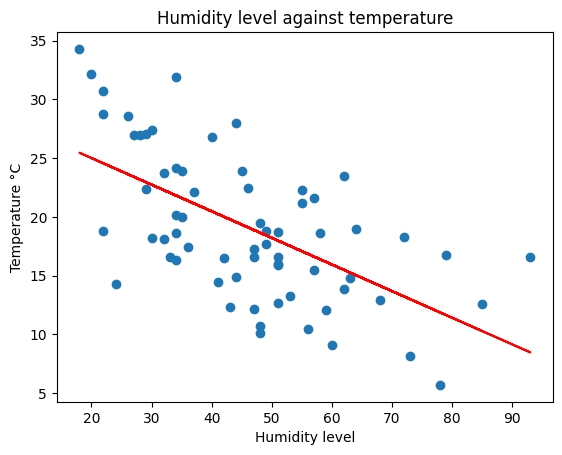

In [10]:
# Plot the prediction (the line) over the true value (the dots)
plt.scatter(X_test, y_test)
plt.plot(X_test, predictions, 'r')
plt.title("Humidity level against temperature")
plt.xlabel('Humidity level')
plt.ylabel('Temperature °C')
plt.show()

We can compare the error of our model by using some metrics like the **MAE (mean absolute error)**, **MSE (mean squared error)** or **coefficient of determination $R^2$** score. Sklearn offers some nice modules to compute these measures ([MAE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error), [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error), [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)).
Here is the import line:

```python
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
```

These metrics takes the `y_test` values and the `predictions` as arguments. Basically it will analyse how far the prediction is from the true value. Using these metrics is very helpful when comparing the performance of model.

In [11]:
# Compute the MAE, the MSE and the R^2
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:0.2f}")
print(f"MSE: {mse:0.2f}")
print(f"R\u00b2: {r2:0.2f} " )

MAE: 4.27
MSE: 24.44
R²: 0.37 


It is also interesting to compare the results of these metrics between the data from the *test set* and those from the *train set* to see whether our model generalizes well:

In [12]:
predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE train set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE train set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 train set: {r2_train:0.2f};" )

MAE test set: 4.27; MAE train set: 4.77;
MSE test set: 24.44; MSE train set: 31.08;
R² test set: 0.37; R² train set: 0.31;


Remember, the higher the $R^2$ value, the better the fit. In this case, the testing data yields a higher coefficient as well as lower mean absolute and mean squared errors. While it might seem a bit counterintuitive, one possible explanation lies in the observations selected when we split our dataset into training/test set. One remedy would be to rely on cross validation.

### Multivariate linear regression

We will now apply the same method to several features, namely, humidity, pressure, wind speed, wind direction, sunshine, rainfall, and cloud data to predict the temperature, still at 3pm.

In [13]:
X = weather[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'WindSpeed3pm', 'WindDir3pm', 'Sunshine', 'Rainfall']] 
y = weather[['Temp3pm']]

#### Splitting dataset <a id='multivariate-split'></a>

We apply the same procedure as before:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

#### Preprocessing: encoding categorical variables

The feature 'WindDir3pm' is a categorical variable. To use it in our model, we need to encode it. Here, we will use a label encoding, using the sklearn module `LabelEncoder`. As an alternative, we could use 1-hot encoding, with the sklearn module `OneHotEncoder`. Here are the import lines:

```python
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
```

**Note:** You should encode your data after splitting the dataset to avoid data leakage (train-test contamination), first transforming the training set and then the test set based on the encoding maps from train data.

In [15]:
print(X_train[['WindDir3pm']])
# Extract the column of interest
wind_dir_3pm = X_train[['WindDir3pm']].values.ravel()
wind_dir_3pm_test = X_test[['WindDir3pm']].values.ravel()
#Define the encoder
le = LabelEncoder()
#Fit the encoder
le.fit(wind_dir_3pm)
#Transform the train and the test set
X_train = X_train.assign(WindDir3pm=le.transform(wind_dir_3pm))
X_test = X_test.assign(WindDir3pm=le.transform(wind_dir_3pm_test))
print(X_train[['WindDir3pm']])

    WindDir3pm
1            W
333         NW
8          ENE
232        WNW
101          W
..         ...
361         NW
204        SSW
119         SE
47           E
179        WNW

[262 rows x 1 columns]
     WindDir3pm
1            13
333           7
8             1
232          14
101          13
..          ...
361           7
204          11
119           9
47            0
179          14

[262 rows x 1 columns]


#### Rescaling

Next, we rescale our data.

**Note:** Generally you should normalize the data right after splitting the dataset. The normalization is important here to reduce the variance of our model and get better results.

We can use the sklearn `MinMaxScaler` module to normalize the data. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one. Here is the import line:

```python
from sklearn.preprocessing import MinMaxScaler
```

In [16]:
#Define the scaler
scaler = MinMaxScaler()
#Fit the scaler
scaler.fit(X_train)
#Transform the train and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Note that these two steps can be merged into one (only for the train set)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

#### Create and Fit model <a id='multivariate-train'></a>

We follow the same steps as before:

In [17]:
# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model.score(X_train, y_train), 3))
# 4. Print the coefficients of the linear model
print("Intercept: ", model.intercept_[0]) 
model_coeff = pd.DataFrame(model.coef_.flatten(), 
                     index=['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'WindSpeed3pm', 'WindDir3pm', 'Sunshine', 'Rainfall'],
                     columns=['Coefficients multivariate model'])
model_coeff # Get the coefficients, w

R² Score of the model:  0.621
Intercept:  37.935966179485945


,Coefficients multivariate model
Humidity3pm,-16.236408
Cloud3pm,2.993911
Pressure3pm,-19.235234
WindSpeed3pm,-13.840040
WindDir3pm,-2.875112
Sunshine,4.779577
Rainfall,-2.598842


The coefficient values inform us about the relative importance of each feature for our prediction.

#### Prediction and evaluation <a id='multivariate-test'></a>

Finally, we evaluate our model performance following the same procedure as before:

In [18]:
# Predict:
predictions = model.predict(X_test)

# Compute the MAE, the MSE and the R^2 on the test set
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE training set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE training set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 training set: {r2_train:0.2f};" )

MAE test set: 3.22; MAE training set: 3.39;
MSE test set: 15.86; MSE training set: 17.13;
R² test set: 0.59; R² training set: 0.62;


The mean absolute error and mean squared error in our multivariate analysis are lower than in the univariate case: as expected, adding more complexity (features) seemed to have improved our prediction.

Note that you should not use the $R^2$ to compare several models since the indicator is sensitive to the number of features. Instead, you can for instance use the [Adjusted $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2).

### Polynomial linear regression

Using polynomial regression enables you to predict the best fit line that follows the pattern (curve) of the data. It tends to increase the performance of the model. We are using the module  `PolynomialFeatures` to preprocess our data ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)):

```python
from sklearn.preprocessing import PolynomialFeatures 
```

The function `PolynomialFeatures` generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. 

In [19]:
# We will use a degree 2
poly = PolynomialFeatures(2)
# Transform our training and test set
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
# Feature name:
X_poly_features = poly.get_feature_names_out(['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'WindSpeed3pm', 'WindDir3pm', 'Sunshine', 'Rainfall'])
print(X_poly_features)

['1' 'Humidity3pm' 'Cloud3pm' 'Pressure3pm' 'WindSpeed3pm' 'WindDir3pm'
 'Sunshine' 'Rainfall' 'Humidity3pm^2' 'Humidity3pm Cloud3pm'
 'Humidity3pm Pressure3pm' 'Humidity3pm WindSpeed3pm'
 'Humidity3pm WindDir3pm' 'Humidity3pm Sunshine' 'Humidity3pm Rainfall'
 'Cloud3pm^2' 'Cloud3pm Pressure3pm' 'Cloud3pm WindSpeed3pm'
 'Cloud3pm WindDir3pm' 'Cloud3pm Sunshine' 'Cloud3pm Rainfall'
 'Pressure3pm^2' 'Pressure3pm WindSpeed3pm' 'Pressure3pm WindDir3pm'
 'Pressure3pm Sunshine' 'Pressure3pm Rainfall' 'WindSpeed3pm^2'
 'WindSpeed3pm WindDir3pm' 'WindSpeed3pm Sunshine' 'WindSpeed3pm Rainfall'
 'WindDir3pm^2' 'WindDir3pm Sunshine' 'WindDir3pm Rainfall' 'Sunshine^2'
 'Sunshine Rainfall' 'Rainfall^2']


Now we proceed as before, performing a linear regression:

In [20]:
# Set up the model
model_poly = LinearRegression(fit_intercept=False) # we don't need fit intercept since polynomial features function add a column of ones to the data 

# Fit
model_poly.fit(X_train_poly, y_train)

# Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model_poly.score(X_train_poly, y_train), 3))

# Print the coefficients of the linear model
model_coeff = pd.DataFrame(model_poly.coef_.flatten(), 
                     index=X_poly_features,
                     columns=['Coefficients polynomial model'])
model_coeff # Get the coefficients, w

R² Score of the model:  0.718


,Coefficients polynomial model
1,70.818534
Humidity3pm,-34.497306
Cloud3pm,-14.110065
Pressure3pm,-58.905587
WindSpeed3pm,-44.953044
WindDir3pm,-16.625414
Sunshine,-18.112180
Rainfall,-2.382792
Humidity3pm^2,5.297209
Humidity3pm Cloud3pm,3.811526


Finally, we evaluate the performance of our model:

In [21]:
# Predict:
predictions = model_poly.predict(X_test_poly)

# Compute the MAE, the MSE and the R^2 on the test set
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = model_poly.predict(X_train_poly)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE training set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE training set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 training set: {r2_train:0.2f};" )

MAE test set: 2.94; MAE training set: 2.90;
MSE test set: 13.84; MSE training set: 12.75;
R² test set: 0.64; R² training set: 0.72;


The mean absolute and mean square errors on the test set decreased. 

However, beware, adding too many features may cause overfitting. Remember that overfitting is is the tendency of data mining procedures to tailor models to the training data, at the expense of generalization to previously unseen data points. 

For instance, if we were to use polynomial features with a degree 3, the mean absolute and mean square errors on the training set would decrease, but the errors on the test set would dramatically increase - and the $R^2$ on the test set would even be negative. Try it!

To avoid such issue, we can implement some regularization techniques.

### Regularization <a id='implement-regul'></a>

We will now implement some regularization techniques discussed above, in combination of our previous polynomial linear regression.

#### Lasso

We can use the sklearn `Lasso` module to implement a Lasso regularization ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)). Here is the import line:

```python
from sklearn.linear_model import Lasso
```

The procedure is the same as before. Since we already split our dataset and preprocessed our training and test sets, we can create the model, fit it, and then evaluate its performance.

When creating the model, we can specify the penalty term, `alpha` as an argument of `Lasso()`:

In [22]:
# Set up the model
lasso_model = Lasso(alpha=0.2, fit_intercept=False)

# Use fit
lasso_model.fit(X_train_poly, y_train)

# Check the score/accuracy
print("R\u00b2 Score of the model: ", round(lasso_model.score(X_train_poly, y_train), 3))

# Print the coefficients of the linear model
model_coeff = pd.DataFrame(lasso_model.coef_.flatten(), 
                     index=X_poly_features,
                     columns=['Coefficients Lasso model'])
model_coeff 

R² Score of the model:  0.424


,Coefficients Lasso model
1,16.480539
Humidity3pm,-3.131065
Cloud3pm,2.723063
Pressure3pm,-0.000000
WindSpeed3pm,-2.157586
WindDir3pm,0.000000
Sunshine,0.000000
Rainfall,-0.000000
Humidity3pm^2,-0.000000
Humidity3pm Cloud3pm,-0.000000


Notice the weights? Most of them were forced to zero, meaning our model will not use the corresponding features for its prediction. The intuition here is that the corresponding features hadn’t provided enough predictive power to be worth considering alongside the other features.

Let's keep going with the evaluation of the model:

In [23]:
# Predict:
predictions = lasso_model.predict(X_test_poly)

# Compute the MAE, the MSE and the R^2 on the test set
mae_lasso = mean_absolute_error(y_test, predictions)
mse_lasso = mean_squared_error(y_test, predictions)
r2_lasso = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = lasso_model.predict(X_train_poly)
mae_train_lasso = mean_absolute_error(y_train, predictions_train)
mse_train_lasso = mean_squared_error(y_train, predictions_train)
r2_train_lasso = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae_lasso:0.2f}; MAE training set: {mae_train_lasso:0.2f};")
print(f"MSE test set: {mse_lasso:0.2f}; MSE training set: {mse_train_lasso:0.2f};")
print(f"R\u00b2 test set: {r2_lasso:0.2f}; R\u00b2 training set: {r2_train_lasso:0.2f};" )

MAE test set: 4.07; MAE training set: 4.20;
MSE test set: 24.21; MSE training set: 26.06;
R² test set: 0.38; R² training set: 0.42;


As a result of Lasso regularization, the MAE and MSE on the test set are increasing. Let's pursue our exploration with a Ridge regularization:

#### Ridge

We can use the sklearn `Ridge` module to implement a Ridge regularization ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)). Here is the import line:

```python
from sklearn.linear_model import Ridge
```

We proceed as before:

In [24]:
# Set up the model
ridge_model = Ridge(alpha=1.0, fit_intercept=False)

# Use fit
ridge_model.fit(X_train_poly, y_train)

# Check the score/accuracy
print("R\u00b2 Score of the model: ", round(ridge_model.score(X_train_poly, y_train), 3))

# Print the coefficients of the linear model
model_coeff = pd.DataFrame(ridge_model.coef_.flatten(),
                     index=X_poly_features,
                     columns=['Coefficients Ridge model'])
model_coeff['Coefficients Lasso model']=lasso_model.coef_.flatten()
model_coeff['Coefficients polynomial model']=model_poly.coef_.flatten()
model_coeff 

R² Score of the model:  0.66


,Coefficients Ridge model,Coefficients Lasso model,Coefficients polynomial model
1,21.167430,16.480539,70.818534
Humidity3pm,-3.083184,-3.131065,-34.497306
Cloud3pm,4.714199,2.723063,-14.110065
Pressure3pm,-1.346583,-0.000000,-58.905587
WindSpeed3pm,-3.411386,-2.157586,-44.953044
WindDir3pm,2.601451,0.000000,-16.625414
Sunshine,8.691005,0.000000,-18.112180
Rainfall,0.266296,-0.000000,-2.382792
Humidity3pm^2,0.421859,-0.000000,5.297209
Humidity3pm Cloud3pm,0.046893,-0.000000,3.811526


Note how the coefficients with the Ridge regularization were shrinked, but not forced to zero as in the Lasso regularization. 

Let's evaluate our new model.

In [25]:
# Predict:
predictions = ridge_model.predict(X_test_poly)

# Compute the MAE, the MSE and the R^2 on the test set
mae_ridge = mean_absolute_error(y_test, predictions)
mse_ridge = mean_squared_error(y_test, predictions)
r2_ridge = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = ridge_model.predict(X_train_poly)
mae_train_ridge = mean_absolute_error(y_train, predictions_train)
mse_train_ridge = mean_squared_error(y_train, predictions_train)
r2_train_ridge = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae_ridge:0.2f}; MAE training set: {mae_train_ridge:0.2f};")
print(f"MSE test set: {mse_ridge:0.2f}; MSE training set: {mse_train_ridge:0.2f};")
print(f"R\u00b2 test set: {r2_ridge:0.2f}; R\u00b2 training set: {r2_train_ridge:0.2f};" )

MAE test set: 3.00; MAE training set: 3.19;
MSE test set: 14.00; MSE training set: 15.38;
R² test set: 0.64; R² training set: 0.66;


Let's visualize the MAE and MSE on the test data obtained in our different models:

In [26]:
model_comparison = pd.DataFrame([mae, mse], index=['MAE', 'MSE'], columns=['Polynomial model'])
model_comparison['LASSO']=[mae_lasso, mse_lasso]
model_comparison['Ridge']=[mae_ridge, mse_ridge]
model_comparison

,Polynomial model,LASSO,Ridge
MAE,2.943465,4.070092,2.997895
MSE,13.838756,24.208311,13.999620


The polynomial and Ridge models seem to perform similarly. 

However, note that the regularization parameter $\alpha$ has a large impact on MAE and MSE in the test data. Moreover, the relationship between the test data MSE and $\alpha$ is complicated and non-monotonic. Hence, one popular method for choosing the regularization parameter is cross-validation, which we will implement below.

### K-fold cross validation

Roughly speaking, cross-validation splits the training dataset into many training/testing subsets, then chooses the regularization parameter value that minimizes the average MSE.

More precisely, k-fold cross-validation does the following:

1. Partition the dataset randomly into k subsets/”folds”.  
2. Compute $MSE_j(\alpha)=$ mean squared error in j-th subset when using the j-th subset as test data, and other k-1 as training data.  
3. Minimize average (across folds) MSE $\min_\alpha \frac{1}{k}\sum_{j=1}^k MSE_j(\alpha)$. 

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width="500">

You can find a more detailed description of cross-validation [here](https://scikit-learn.org/stable/modules/cross_validation.html).

We will implement cross validation in addition of our previous polynomial linear regression with ridge regularization. We are using the sklearn `RidgeCV` module ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)). Here is the import line:

```python
from sklearn.linear_model import RidgeCV
```

In case, a similar module exists for Lasso regularization with cross-validation, namely `LassoCV` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)).

With the argument `cv`, we can specify the number of folds:

In [27]:
# Set up the model
ridge_cv_model = RidgeCV(cv=5, fit_intercept=False)

# Use fit
ridge_cv_model.fit(X_train_poly, y_train)

# Check the score/accuracy
print("R\u00b2 Score of the model: ", round(ridge_cv_model.score(X_train_poly, y_train), 3))

# Print the coefficients of the linear model
model_coeff['Coefficients Ridge-CV model']=ridge_cv_model.coef_.flatten()
model_coeff 

R² Score of the model:  0.701


,Coefficients Ridge model,Coefficients Lasso model,Coefficients polynomial model,Coefficients Ridge-CV model
1,21.167430,16.480539,70.818534,29.980247
Humidity3pm,-3.083184,-3.131065,-34.497306,-8.429711
Cloud3pm,4.714199,2.723063,-14.110065,2.558045
Pressure3pm,-1.346583,-0.000000,-58.905587,-8.230082
WindSpeed3pm,-3.411386,-2.157586,-44.953044,-13.383001
WindDir3pm,2.601451,0.000000,-16.625414,-0.909233
Sunshine,8.691005,0.000000,-18.112180,11.709118
Rainfall,0.266296,-0.000000,-2.382792,0.906458
Humidity3pm^2,0.421859,-0.000000,5.297209,2.632328
Humidity3pm Cloud3pm,0.046893,-0.000000,3.811526,0.296088


As always, let's evaluate our model:

In [28]:
# Predict:
predictions = ridge_cv_model.predict(X_test_poly)

# Compute the MAE, the MSE and the R^2 on the test set
mae_ridge_cv = mean_absolute_error(y_test, predictions)
mse_ridge_cv = mean_squared_error(y_test, predictions)
r2_ridge_cv = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = ridge_cv_model.predict(X_train_poly)
mae_train_ridge_cv = mean_absolute_error(y_train, predictions_train)
mse_train_ridge_cv = mean_squared_error(y_train, predictions_train)
r2_train_ridge_cv = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae_ridge:0.2f}; MAE training set: {mae_train_ridge:0.2f};")
print(f"MSE test set: {mse_ridge:0.2f}; MSE training set: {mse_train_ridge:0.2f};")
print(f"R\u00b2 test set: {r2_ridge:0.2f}; R\u00b2 training set: {r2_train_ridge:0.2f};" )

MAE test set: 3.00; MAE training set: 3.19;
MSE test set: 14.00; MSE training set: 15.38;
R² test set: 0.64; R² training set: 0.66;


Let's compare our model to the previous ones:

In [29]:
model_comparison['Ridge with Cross Validation']=[mae_ridge_cv, mse_ridge_cv]
model_comparison

,Polynomial model,LASSO,Ridge,Ridge with Cross Validation
MAE,2.943465,4.070092,2.997895,2.899290
MSE,13.838756,24.208311,13.999620,13.345064


By optimizing the regularization parameter, the MAE and MSE decreased a little.

## Your turn


Now it's your turn to play with ML algorithms! In this application, you will study the energy efficiency of buildings. More precisely, you will try to predict the heating loads of buildings based on the following features:
- X1 Relative Compactness
- X2 Surface Area
- X3 Wall Area
- X4 Roof Area
- X5 Overall Height
- X6 Orientation
- X7 Glazing Area
- X8 Glazing Area Distribution

You will use the [Energy-Efficiency-Dataset](https://www.openml.org/search?type=data&status=active&id=43338), created by Angeliki Xifara, processed by Athanasios Tsanas, and made available on [OpenML](https://www.openml.org/), an open platform for sharing datasets, algorithms, and experiments.

The format of the dataset is called "arff" (Attribute Relation File Format). You can open these files using the [Scipy](https://scipy.org/) library. To open such file from an URL, you will also need to import `urllib.request` and `io`. If everything is installed, you can run the following lines of code to obtain a dataframe:

In [30]:
url = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/energy-efficiency.arff'
ftpstream = urllib.request.urlopen(url)
data = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))
df = pd.DataFrame(data[0])

**Discover your dataset**

- Explore your dataset, displaying a few observations, the types of your data, some summary statistics, the correlation matrix. Feel free to push forward your EDA, for instance using some graphs

In [31]:
# YOUR CODE HERE

# Display a sample of the data
display(df.head())

# Display the data types
display(df.dtypes)

# Summary statistics
display(df.describe())

# Correlation matrix
df.corr()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6    float64
X7    float64
X8    float64
Y1    float64
Y2    float64
dtype: object

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
X1,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,5.878473e-17,-2.096261e-15,-1.896390e-16,0.622272,0.634339
X2,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,-3.066832e-17,3.623317e-15,2.441409e-15,-0.658120,-0.672999
X3,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,-2.510469e-17,-8.647953e-17,2.077332e-16,0.455671,0.427117
X4,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,-5.591507e-17,-1.753224e-15,-1.068485e-15,-0.861828,-0.862547
X5,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,4.876676e-17,-1.977685e-16,-9.524163e-17,0.889431,0.895785
X6,5.878473e-17,-3.066832e-17,-2.510469e-17,-5.591507e-17,4.876676e-17,1.000000e+00,-9.366058e-16,-2.608346e-16,-0.002587,0.014290
X7,-2.096261e-15,3.623317e-15,-8.647953e-17,-1.753224e-15,-1.977685e-16,-9.366058e-16,1.000000e+00,2.129642e-01,0.269841,0.207505
X8,-1.896390e-16,2.441409e-15,2.077332e-16,-1.068485e-15,-9.524163e-17,-2.608346e-16,2.129642e-01,1.000000e+00,0.087368,0.050525
Y1,6.222722e-01,-6.581202e-01,4.556712e-01,-8.618283e-01,8.894307e-01,-2.586534e-03,2.698410e-01,8.736759e-02,1.000000,0.975862
Y2,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,1.428960e-02,2.075050e-01,5.052512e-02,0.975862,1.000000


We visualize our correlation matrix with a heatmap, using `seaborn` library:

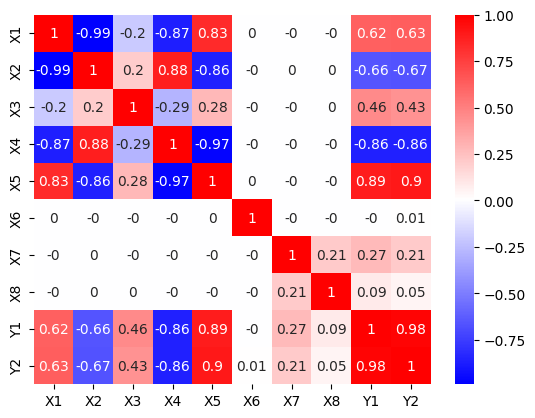

In [32]:
sns.heatmap(df.corr().round(decimals=2), annot=True, cmap="bwr")
plt.show()

Let's do a boxplot. Since the features have very different values, we do separate boxplot for each:

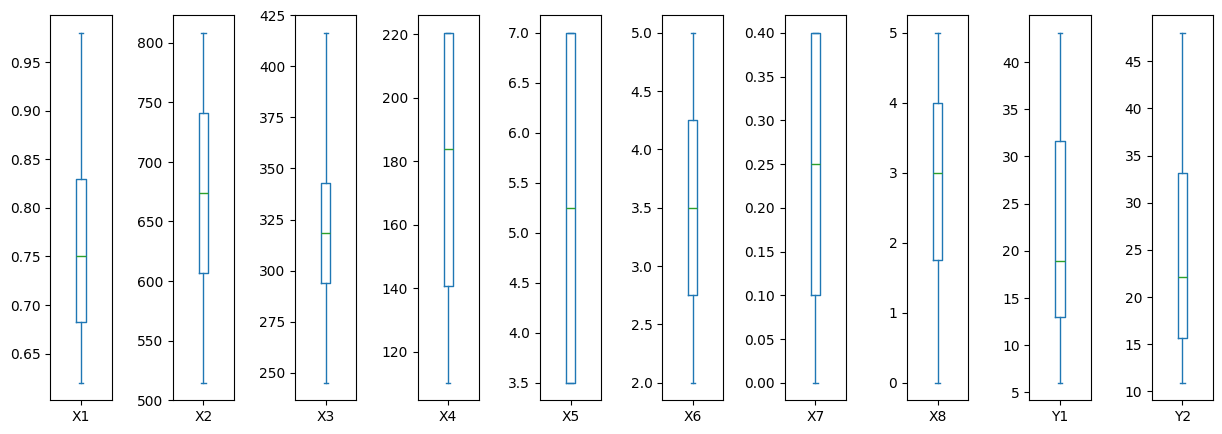

In [33]:
df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 5)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=1) 
plt.show()

Let's do a pairplot:

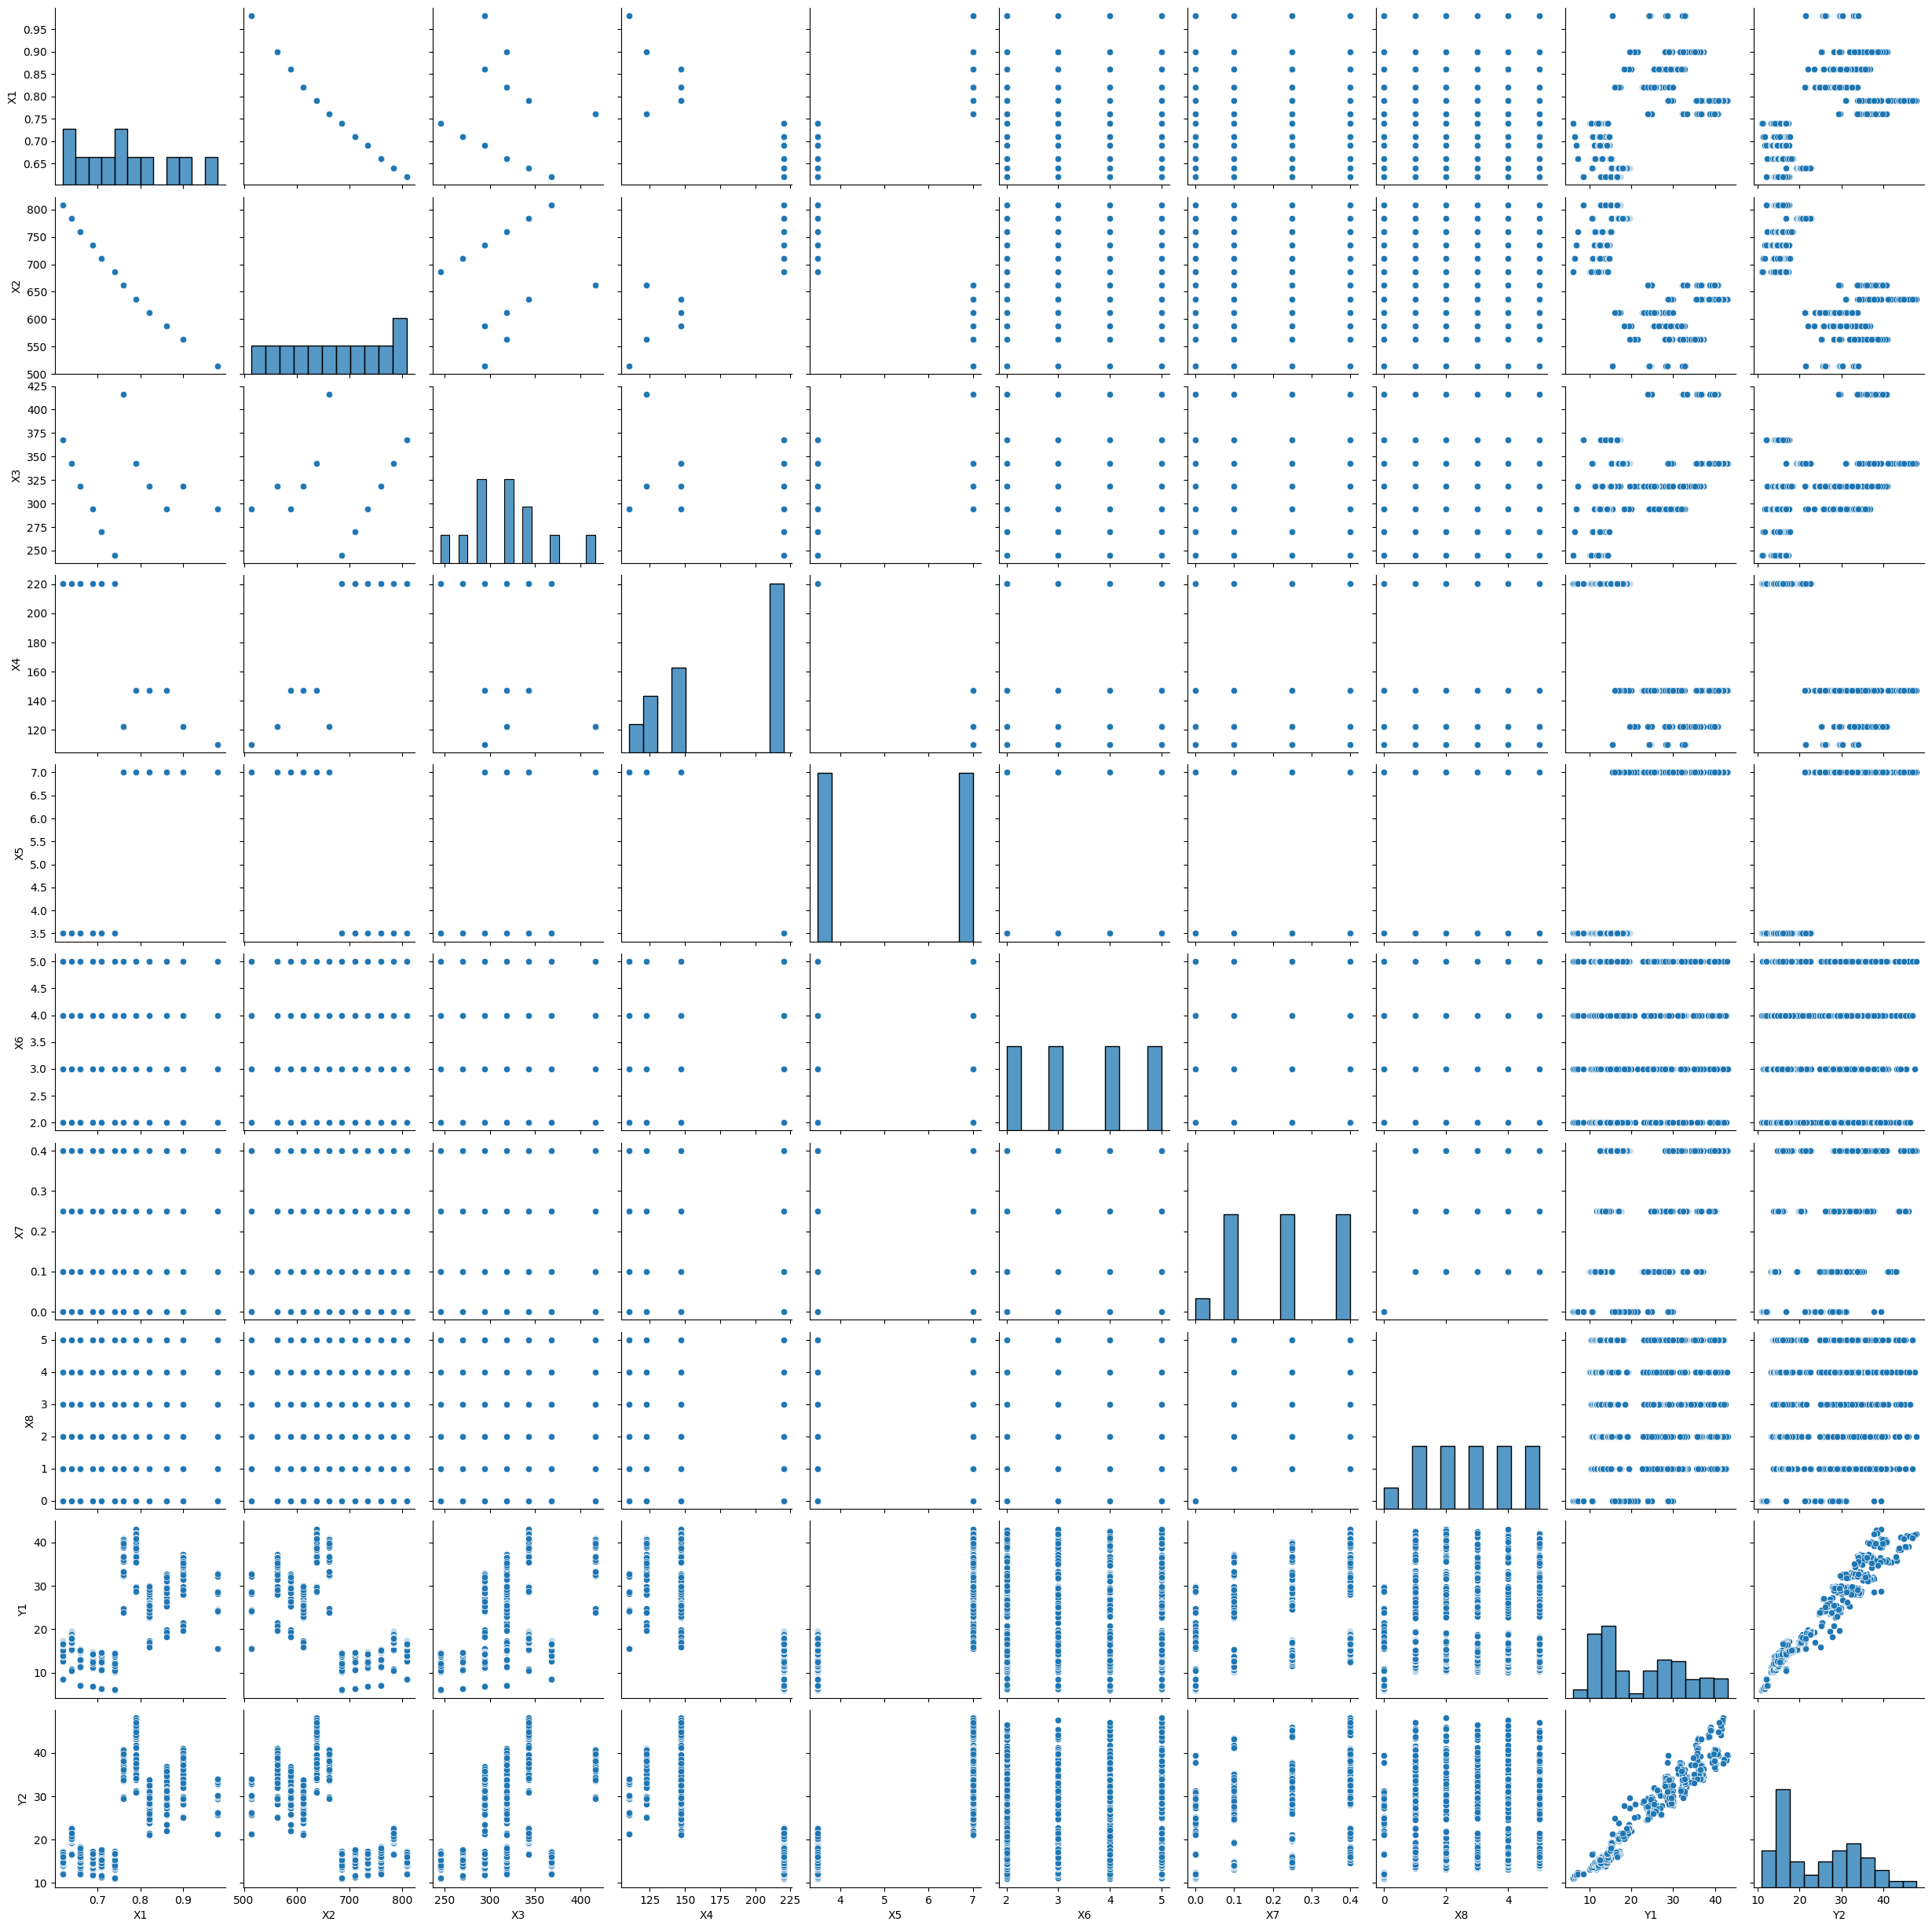

In [34]:
sns.pairplot(df) 
plt.show()

**Multivariate linear regression**

You will first implement a multivariate linear regression, using all the features X to predict the heating load Y1.

- Select your features and split your dataset between training and test set, using a 80-20 split

In [35]:
# YOUR CODE HERE

# We select our features:
X = df[['X1','X2','X3','X4','X5','X6','X7','X8']]
y = df[['Y1']]

# We split our dataset:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

- Rescale your features

In [36]:
# YOUR CODE HERE

# Select scaler:
scaler = MinMaxScaler()
# Fit scaler and transform training set
X_train = scaler.fit_transform(X_train)
# Transform test set
X_test = scaler.transform(X_test)

- Create a linear regression model and train it.

In [37]:
# YOUR CODE HERE

# Create model
model = LinearRegression()
# Train model
model.fit(X_train, y_train)

LinearRegression()

- What is the $R^2$ of your model?
- Display a dataframe with the coefficients of your model. Which ones are relatively more important? Can you interpret this result using your intuition?

In [38]:
# YOUR CODE HERE

# Compute and display R^2
print("R\u00b2 Score of the model: ", round(model.score(X_train, y_train), 3))

# Print intercept
print("Intercept: ", model.intercept_[0]) 

# Feature names
features = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area' , 'Glazing Area Distribution']

# Create dataframe with feature names and associated coefficients
model_coeff = pd.DataFrame(model.coef_.flatten(), 
                     index=features,
                     columns=['Coefficients multivariate model'])
model_coeff

R² Score of the model:  0.918
Intercept:  29.166328749348512


,Coefficients multivariate model
Relative Compactness,-20.762686
Surface Area,-7.980007
Wall Area,1.541693
Roof Area,-11.839104
Overall Height,14.184758
Orientation,-0.062678
Glazing Area,7.923938
Glazing Area Distribution,0.798258


- What are the MAE, MSE, and $R^2$ on the test data? How do they compare to the same metrics on the training data?

We will write a function to automate the procedure since we will perform the same operations for several models. In addition, we will store the MAE and MSE in a dataframe to compare their values with other models at the end.

In [39]:
def errors_model(X_test, y_test, X_train, y_train, model, model_name):
    """This function computes the MAE, MSE, R^2 of a predictive model, both on the test set and on the training set."""
    # Predict on test set
    predictions = model.predict(X_test)
    # Compute the MAE, the MSE and the R^2 on the test set
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    # Compute the MAE, the MSE and the R^2 on the training set
    predictions_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    r2_train = r2_score(y_train, predictions_train)
    # Print results
    print(f"MAE test set: {mae:0.2f}; MAE training set: {mae_train:0.2f};")
    print(f"MSE test set: {mse:0.2f}; MSE training set: {mse_train:0.2f};")
    print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 training set: {r2_train:0.2f};" )
    # We also create a dataframe with the results MAE and MSE for the test set 
    df_errors = pd.DataFrame([mae, mse], index=['MAE', 'MSE'], columns=[model_name])
    return df_errors

In [40]:
errors_multivariate = errors_model(X_test, y_test, X_train, y_train, model, 'Multivariate')

MAE test set: 2.22; MAE training set: 2.01;
MSE test set: 10.10; MSE training set: 8.16;
R² test set: 0.91; R² training set: 0.92;


Our MAE and MSE increase a bit, but stay comparable. Similarly the $R^2$ is similar. It seems that our model can be generalized.

**Polynomial linear regression**

- Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to 2

In [41]:
# YOUR CODE HERE

# Create polynomial model with 2 degrees
poly = PolynomialFeatures(2)

# Fit model and transform train set
X_train_poly = poly.fit_transform(X_train)

# Transform test set
X_test_poly = poly.transform(X_test)

# Get new feature names
X_poly_features = poly.get_feature_names_out(features)
print(X_poly_features)

['1' 'Relative Compactness' 'Surface Area' 'Wall Area' 'Roof Area'
 'Overall Height' 'Orientation' 'Glazing Area' 'Glazing Area Distribution'
 'Relative Compactness^2' 'Relative Compactness Surface Area'
 'Relative Compactness Wall Area' 'Relative Compactness Roof Area'
 'Relative Compactness Overall Height' 'Relative Compactness Orientation'
 'Relative Compactness Glazing Area'
 'Relative Compactness Glazing Area Distribution' 'Surface Area^2'
 'Surface Area Wall Area' 'Surface Area Roof Area'
 'Surface Area Overall Height' 'Surface Area Orientation'
 'Surface Area Glazing Area' 'Surface Area Glazing Area Distribution'
 'Wall Area^2' 'Wall Area Roof Area' 'Wall Area Overall Height'
 'Wall Area Orientation' 'Wall Area Glazing Area'
 'Wall Area Glazing Area Distribution' 'Roof Area^2'
 'Roof Area Overall Height' 'Roof Area Orientation'
 'Roof Area Glazing Area' 'Roof Area Glazing Area Distribution'
 'Overall Height^2' 'Overall Height Orientation'
 'Overall Height Glazing Area' 'Overall 

- Train a linear regression model with polynomial features
- What is the $R^2$

In [42]:
# YOUR CODE HERE

# Set up the model
model_poly = LinearRegression(fit_intercept=False) # we don't need fit intercept since polynomial features function add a column of ones to the data 
# Fit
model_poly.fit(X_train_poly, y_train)

# Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model_poly.score(X_train_poly, y_train), 3))

R² Score of the model:  0.995


- What are the MAE, MSE, and $R^2$ on the test data? How do they compare to the same metrics on the training data?

We can use our previously defined function!

In [43]:
# YOUR CODE HERE

errors_polynomial = errors_model(X_test_poly, y_test, X_train_poly, y_train, model_poly, 'Polynomial')

MAE test set: 0.62; MAE training set: 0.52;
MSE test set: 0.68; MSE training set: 0.48;
R² test set: 0.99; R² training set: 1.00;


The $R^2$ of one on the training set is suspicious, since it indicates a perfect fit. Could it be overfitting? Well, the errors are quite low and similar between training and test set so it seems that we have no overfitting issues, and we designed a great predictive model.

**Regularization**

- Train a linear regression model with polynomial features and ridge regression
- What are the MAE, MSE, and $R^2$ on the test data?

In [44]:
# YOUR CODE HERE

# Create and Fit model, all in one line!
ridge_model = Ridge(alpha=1.0, fit_intercept=False).fit(X_train_poly, y_train)

# Compute errors using our function:
errors_ridge = errors_model(X_test_poly, y_test, X_train_poly, y_train, ridge_model, 'Ridge')

MAE test set: 1.94; MAE training set: 1.70;
MSE test set: 7.68; MSE training set: 6.06;
R² test set: 0.93; R² training set: 0.94;


- Train a linear regression model with polynomial features and lasso regression
- What are the MAE, MSE, and $R^2$ on the test data?

In [45]:
# YOUR CODE HERE

# Create and Fit model, all in one line!
lasso_model = Lasso(alpha=1, fit_intercept=False).fit(X_train_poly, y_train)

# Compute errors using our function:
errors_lasso = errors_model(X_test_poly, y_test, X_train_poly, y_train, lasso_model, 'LASSO')

MAE test set: 3.30; MAE training set: 2.89;
MSE test set: 21.67; MSE training set: 16.49;
R² test set: 0.80; R² training set: 0.83;


**Cross-validation**

- Train a linear regression model with polynomial features, cross-validation, and the regularization technique of your choice (you can even explore other ones, such as Elastic Net)
- What are the MAE, MSE, and $R^2$ on the test data?

We will use Lasso regularization with cross validation `LassoCV` to try a technique we did not implement before:

In [46]:
y_test.values.flatten()

array([15.18, 10.32, 37.26, 16.95, 32.26, 27.9 , 28.18, 28.95, 29.07,
       23.8 ,  6.4 , 42.5 , 11.22, 43.1 , 41.96, 26.33, 10.7 , 28.09,
       14.65, 12.29, 12.46, 32.71, 10.77, 38.57,  6.04, 14.66, 13.  ,
       14.41, 10.75, 39.89, 12.74, 12.74, 41.26, 12.77, 28.56, 35.99,
       13.97, 35.69, 17.14, 10.85, 11.6 , 39.97, 14.42, 25.17, 19.5 ,
       24.4 , 13.69, 12.12, 28.86, 32.75, 32.24, 12.97, 32.31, 14.96,
       36.95, 10.39, 15.55, 26.19, 40.12, 14.53, 14.72, 12.33, 32.23,
       10.34, 12.65, 11.8 , 38.98, 11.21, 25.36, 39.83, 32.82, 10.53,
       23.89, 17.26, 15.16, 24.94, 32.85, 38.65, 32.84, 14.51, 35.69,
       29.62, 11.69, 14.16, 29.92, 25.38, 24.03, 29.63, 12.85, 17.15,
       14.18, 26.45, 12.5 , 24.63, 40.78, 15.09, 29.47, 14.75,  7.1 ,
       35.64, 36.97, 22.93, 19.34, 32.96, 10.39, 29.88, 42.11, 12.92,
       12.57, 15.55, 17.69, 33.09, 32.13, 15.36, 12.19, 15.36, 11.34,
       36.77, 26.45, 38.82, 35.01, 12.16, 12.57, 36.06, 12.28, 40.6 ,
       14.32, 28.17,

In [47]:
# YOUR CODE HERE

# Create and fit model, with 5 folds:
lasso_cv_model = LassoCV(cv=5, fit_intercept=False).fit(X_train_poly, y_train.values.flatten())

# Erros:
errors_cv = errors_model(X_test_poly, y_test.values.flatten(), X_train_poly, y_train.values.flatten(), lasso_cv_model, 'LASSO with Cross Validation')

MAE test set: 1.97; MAE training set: 1.79;
MSE test set: 8.59; MSE training set: 6.85;
R² test set: 0.92; R² training set: 0.93;


**Model comparison**

- Compare your models. Which one gives the most accurate prediction?
- Display the coefficients of your best model. What do you observe?

We will concatenate our previously obtained dataframes:

In [48]:
# YOUR CODE HERE

# compile the list of dataframes you want to merge
df_errors_list = [errors_multivariate, errors_polynomial, errors_ridge, errors_lasso, errors_cv]
model_comparison = pd.concat(df_errors_list, axis=1)
model_comparison

,Multivariate,Polynomial,Ridge,LASSO,LASSO with Cross Validation
MAE,2.222083,0.620919,1.944348,3.298777,1.973989
MSE,10.097917,0.680998,7.683001,21.672429,8.586230


We had already observed that the Polynomial model lead to very good predictions, and regularization was probably not needed in our case (but it's always fun to explore several models). Ridge performs better than LASSO. When we optimize the LASSO penalty term with cross validation, we obtain similar results than with Ridge. 

**Note:** We did not use the $R^2$ because our models have a different number of features, hence comparing $R^2$ would be misleading. Instead, we could have computed the adjusted $R^2$

Let's print the coefficients of our polynomial model:

In [49]:
model_coeff = pd.DataFrame(model_poly.coef_.flatten(), 
                     index=X_poly_features,
                     columns=['Coefficients polynomial model'])
model_coeff

,Coefficients polynomial model
1,-11668.832065
Relative Compactness,22891.579389
Surface Area,515.142014
Wall Area,7190.467778
Roof Area,-7498.803824
Overall Height,-1566.114719
Orientation,-0.763462
Glazing Area,21.768783
Glazing Area Distribution,9.563346
Relative Compactness^2,-21870.316866


We obtained extremely high and low values, which we cannot really interpret. There are several possible explanations:
- the features might not be properly scaled: here, it is not the issue, our scaling made our features comparable.
- overfitting: we compared the performance of our model on the training and test sets., and obtained good performance for both, so overfitting does not seem like the issue.
- collinearity between features: bingo! if we check our correlation matrix, we see that we have a correlation of almost 1 between X1 and X2

So, is it an issue? Well, it depends. If all we care about is good prediction, it is not critical, although we need to be careful that our model can be generalized to new data. 

However, we may care about intepretability, for instance, if we want to gain insights into the underlying factors driving our predictions or if we want to communicate our results in an understandable way. What do we do in this case? We have several options:
- either remove one of the correlated features or combine them into a single feature
- implement regularization (as we did) to shrink coefficients (Ridge) or select features (LASSO)
- explore alternative models

Let's see how regularization modified our coefficients:

In [50]:
model_coeff['Coefficients RIDGE model'] = ridge_model.coef_.flatten()
model_coeff['Coefficients LASSO model'] = lasso_model.coef_.flatten()
model_coeff['Coefficients LASSO-CV model'] = lasso_cv_model.coef_.flatten()
model_coeff

,Coefficients polynomial model,Coefficients RIDGE model,Coefficients LASSO model,Coefficients LASSO-CV model
1,-11668.832065,2.826509,10.802822,7.180690
Relative Compactness,22891.579389,2.557123,0.000000,0.000000
Surface Area,515.142014,2.249243,0.000000,0.000000
Wall Area,7190.467778,3.553134,0.151052,2.431144
Roof Area,-7498.803824,0.863554,0.000000,0.000000
Overall Height,-1566.114719,3.853848,15.739066,10.912068
Orientation,-0.763462,-0.666793,0.000000,0.000000
Glazing Area,21.768783,5.471534,4.349949,6.962932
Glazing Area Distribution,9.563346,2.700909,0.000000,1.915740
Relative Compactness^2,-21870.316866,1.800994,0.000000,-0.000000


Here we go, we obtained interpretable coefficients!

Feel free to try to improve the prediction of your model implementing other algorithms, preprocessing techniques, and playing with the parameters of your model...

In [51]:
# YOUR CODE HERE

